In [1]:
import time
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [2]:
coins_w_data = cg.get_coins_markets(vs_currency='usd',per_page=100)

Market_cap = {}
for n in range(len(coins_w_data)):
    Market_cap[n] ={ 'ID': coins_w_data[n]['id'] }
coins_df_w_mark_cap = pd.DataFrame.from_dict(Market_cap).T.set_index('ID')

In [3]:
s,e = "01/01/2019", "06/01/2022"
start = time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple())
end = time.mktime(datetime.strptime(e, "%d/%m/%Y").timetuple())

In [4]:
#grab price and market cap data in two tables
#create dataframe when calling first asset
holding_frame = cg.get_coin_market_chart_range_by_id(id = coins_df_w_mark_cap.index[0], vs_currency='usd', from_timestamp = start, to_timestamp = end)
Market_cap_df = pd.DataFrame(holding_frame['market_caps']).rename(columns = {0:'date', 1:str(coins_df_w_mark_cap.index[0])}).set_index('date')
price_df = pd.DataFrame(holding_frame['prices']).rename(columns = {0:'date', 1:str(coins_df_w_mark_cap.index[0])}).set_index('date')

for n in coins_df_w_mark_cap.index[1:]:
    try:
        holding_frame = cg.get_coin_market_chart_range_by_id(id = n, vs_currency='usd', from_timestamp = start, to_timestamp = end)
        
        Market_cap_temp = pd.DataFrame(holding_frame['market_caps']).rename(columns = {0:'date', 1:str(n)}).set_index('date')
        price_df_temp = pd.DataFrame(holding_frame['prices']).rename(columns = {0:'date', 1:str(n)}).set_index('date')
    
        Market_cap_df = pd.concat([Market_cap_df,Market_cap_temp], axis=1)
        price_df = pd.concat([price_df,price_df_temp], axis=1)
    except:
        print("issue with", n)

In [5]:
#convert index from unix to dates
price_df.index = pd.to_datetime(price_df.index,unit='ms')
Market_cap_df.index = pd.to_datetime(Market_cap_df.index,unit='ms')

#fill na with zeros
price_df_clean = price_df.fillna(0)
Market_cap_df_clean = Market_cap_df.fillna(0)

#use to cut out stablecoins
ex_stablecoins = price_df_clean.columns[price_df.std()>.01] 
price_df_ex_stable = price_df_clean[ex_stablecoins]
Market_cap_df_ex_stable = Market_cap_df_clean[ex_stablecoins]

#exclude stablecoins from calculation of global cap
global_cap = Market_cap_df_ex_stable.sum(axis=1)
percent_cap = Market_cap_df_ex_stable.divide(global_cap,axis=0)

#returns
daily_returns = price_df_ex_stable.pct_change().fillna(0).replace(np.inf,0)

In [6]:
def backtest(weights, col, dataf, cap_weight, days_between_rebalance, rebalance_func, show_weights=False, wealth = 1, RebalanceOffset=0,formation = 0): #cols allows users to backtest subsets of dataframe
    """
    weights: tells the function the number of assets. sets the starting weights and is the weights for constant rebalancing
    wealth: sets starting value
    RebalanceOffset: to offset day of rebalances by these values to avoid rebalance timing luck
    formation: number of days historical prices used in rebalance
    
    """
    colin=[0]*len(weights) #to store asset indexes
    port=[0]*len(weights)
    worth=[wealth]
    turnover = []

    for n in range(len(weights)):                 #select assets
        colin[n] = dataf.columns.get_loc(col[n])
        port[n]=wealth*weights[n]

    for n in range (formation,len(dataf)):
        port = np.multiply(port, np.array((1+dataf.iloc[n,colin]))) 
        end_of_day = np.sum(port)
        worth.append(end_of_day)
        
        if ((n + RebalanceOffset)% days_between_rebalance==0):        #rebalance
            port,turn=rebalance_func(dataf, cap_weight, n, formation, port, weights, sum(port))
            turnover.append(turn)
            if show_weights == True:
                
                print(np.round(np.array(port/sum(port)),2))
            
                           
    p_rtn = pd.DataFrame(worth).pct_change()[1:].set_index(dataf.index[formation:])
    return(p_rtn,turnover)

In [7]:
def cap_weight_rebalance(stocks, cap_weight, n, formation_period, port, weights, total):
    ave_of_historical_cap_weight = cap_weight[n - formation_period : n - 1].mean()
    columns_to_set_to_0 = set(ave_of_historical_cap_weight.index) - set(ave_of_historical_cap_weight.nlargest(10).index)
    weightings = ave_of_historical_cap_weight.copy()
    weightings[columns_to_set_to_0] = 0
    normalized_weights = (weightings/weightings.sum()).values
    
    update = np.subtract(np.array(normalized_weights), np.array(port/total))/4   #reduce turnover and rebalance timing luck by moving towards optimal value instead of jumping to it
    
    new_port = np.add(np.array(port/total),update)    #update portfolio weights
    #print(np.round(new_port,2),n)                       #print weights
    
    return total * new_port, abs(update).sum()/2

In [8]:
#set initial weightings -to work with backtest function
#index methodology. invest in 10 largest coins quarterly proportional to their previous month's market cap percent
num=0
columns_to_set_to_0 = set(percent_cap.columns) - set(percent_cap.iloc[num].nlargest(10).index)
weightings = percent_cap.iloc[num].copy()
weightings[columns_to_set_to_0] = 0
normalized_weights = (weightings/weightings.sum()).values

In [9]:
# find sensativity to formation period, maximize returns 
for n in [5,10,22,30,60]:
    index,turnover = backtest(normalized_weights, daily_returns.columns, daily_returns, percent_cap, days_between_rebalance = 90, rebalance_func = cap_weight_rebalance, formation = n)
    print("formed over",n,"days","Mean:", index.mean()*365,"Std:",index.std()*np.sqrt(365),"skew:", index.skew(),"total turnover", sum(turnover))
    print()

formed over 5 days Mean: 0    1.108836
dtype: float64 Std: 0    0.756192
dtype: float64 skew: 0   -0.723556
dtype: float64 total turnover 0.11064825410881961

formed over 10 days Mean: 0    1.135489
dtype: float64 Std: 0    0.755901
dtype: float64 skew: 0   -0.723168
dtype: float64 total turnover 0.10846287154411743

formed over 22 days Mean: 0    1.156094
dtype: float64 Std: 0    0.759054
dtype: float64 skew: 0   -0.733364
dtype: float64 total turnover 0.12231893450385087

formed over 30 days Mean: 0    1.178275
dtype: float64 Std: 0    0.761564
dtype: float64 skew: 0   -0.735774
dtype: float64 total turnover 0.1311741250940934

formed over 60 days Mean: 0    1.168826
dtype: float64 Std: 0    0.764378
dtype: float64 skew: 0   -0.742791
dtype: float64 total turnover 0.12419589635416178



In [10]:
#sensativity to days between rebalancing
for n in [30,60,90,150,365]:
    temp = {}
    for i in range(0,n,5): #run each backtest with different starting days to get a proxy for the luck of when you rebalance
        index,turnover = backtest(normalized_weights, daily_returns.columns, daily_returns, percent_cap, days_between_rebalance = n, rebalance_func = cap_weight_rebalance, formation = 30,RebalanceOffset = i)
        temp[i] = {'mean':index.mean().values[0]*365,'std':index.std().values[0]*np.sqrt(365),'skew':index.skew().values[0],'total turnover':sum(turnover)}
        df = pd.DataFrame(temp).mean(axis=1).round(4)
    print("days between rebalance:",n,"Mean:", df['mean'],"Std:", df['std'],"skew:", df['skew'],"total turnover", df['total turnover'], "return dispersion", pd.DataFrame(temp).std(axis=1)['mean'])
    print()

days between rebalance: 30 Mean: 1.1756 Std: 0.7595 skew: -0.7345 total turnover 0.3051 return dispersion 0.002837952668962544

days between rebalance: 60 Mean: 1.1753 Std: 0.7596 skew: -0.7319 total turnover 0.1771 return dispersion 0.004083366958224512

days between rebalance: 90 Mean: 1.1755 Std: 0.7596 skew: -0.7309 total turnover 0.1277 return dispersion 0.0027315200388714905

days between rebalance: 150 Mean: 1.1755 Std: 0.7596 skew: -0.729 total turnover 0.0862 return dispersion 0.0027561517667927878

days between rebalance: 365 Mean: 1.1742 Std: 0.7596 skew: -0.7258 total turnover 0.0419 return dispersion 0.00359664625227278



In [11]:
returns, turnover = backtest(normalized_weights, daily_returns.columns, daily_returns, percent_cap, days_between_rebalance = 90, rebalance_func = cap_weight_rebalance, formation = 30,RebalanceOffset = i)

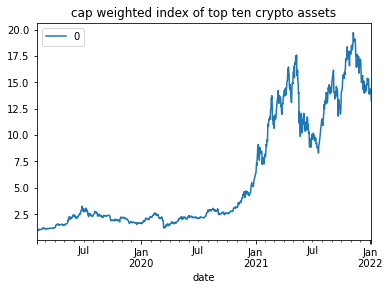

In [12]:
(returns+1).cumprod().plot()
plt.title("cap weighted index of top ten crypto assets")
plt.show()